### Your name:

<pre> Helen Ng </pre>




# Assignment for Module 4: Clustering

## Description

In this assignment you will study the electric demand (power) of clients in Portugal, during 2013 and 2014.

The data$^1$ available contains 370 time series, corresponding to the electric demand$^2$ for 370 clients, between 2011 and 2014. 

In this guided exercise you will use clustering techniques to understand the typical behaviour during 2013-2014.

#### 1. Data:
https://archive.ics.uci.edu/ml/datasets/ElectricityLoadDiagrams20112014#

#### 2. Electric Demand:
http://www.think-energy.net/KWvsKWH.htm


## Data Preparation

Start by downloading the data to a local directory and modify the "pathToFile" and "fileName" variables, if needed

In [105]:
pathToFile = r"C:/Users/nghel/Downloads/LD2011_2014.txt"
fileName = 'LD2011_2014.txt'

In [107]:
import numpy as np
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import random
from sklearn.metrics import silhouette_score
from sklearn.cluster import AgglomerativeClustering
random.seed(42)

In [ ]:
# Create dataframe
import pandas as pd
data = pd.read_csv(pathToFile+fileName, sep=";", index_col=0)

### Quick data inspection

In [ ]:
data.head(2)

In [ ]:
data.tail(2)

In [ ]:
data.shape

#### As can be seen, the dataframe contains a row for each interval of 15 minutes between Jan 1, 2011 to Dec 31 2014. There are 370 columns corresponding 370 clients. The dataframe is indexed by the timestamp.

Since the frequency is 15 minutes, each day provides $24\times 4 = 96$ datapoints, which multiplied by 365 days and 4 years (plus 1 day in Feb 29, 2012) gives: $96 \times 365 \times 4 + 96 = 140256$, as observed in data.shape

In [ ]:
data.info()

In [ ]:
data.describe()

### Plot the 2 days of 2012 for the first 2 clients

In [ ]:
data_example = data.loc['2012-01-01 00:15:00':'2012-01-03 00:00:00'][['MT_001','MT_002']]
data_example.plot()
plt.show()

#### We quickly note that the main difference between the curves is the level (also seen on the means in df.describe()), so we know we will have to somehow normalize the curves, in order for the clustering technique to capture the behaviour of the consumption throughout the day, rather than the overall level.

### Data for the analysis

We focus on 2013 and 2014 because these are the years with lower number of clients having zero demand

In [ ]:
data2011 = data.loc['2011-01-01 00:15:00':'2012-01-01 00:00:00']
data2012 = data.loc['2012-01-01 00:15:00':'2013-01-01 00:00:00']
data2013 = data.loc['2013-01-01 00:15:00':'2014-01-01 00:00:00']
data2014 = data.loc['2014-01-01 00:15:00':'2015-01-01 00:00:00']

In [ ]:
# Check number of days
print(data2011.shape[0]/96)
print(data2012.shape[0]/96)
print(data2013.shape[0]/96)
print(data2014.shape[0]/96)

In [ ]:
# See number of clients with 0 demand per year
print(sum(data2011.mean()==0))
print(sum(data2012.mean()==0))
print(sum(data2013.mean()==0))
print(sum(data2014.mean()==0))

In [ ]:
clients = data2011.columns
clients_no_demand = clients[data2013.mean()==0] # clients with 0 demand
data_13_14 = data2013.append(data2014) # appending 2013 and 2014
data_13_14 = data_13_14.drop(clients_no_demand, axis=1) # drop clients with 0 demand
print(data_13_14.shape)
print(sum(data_13_14.mean()==0)) # check that there are no clients with 0 demand

## Getting average curves per client

In [ ]:
data = data_13_14.copy() # weekdays weekends, data2011, data2012, data2013, data2014

In [ ]:
data['hour'] = data.index.map(lambda x: x[11:])

In [ ]:
data.head(3)

### Getting average curves per client

In [ ]:
datagrouped = data.groupby("hour")
average_curves = datagrouped.agg("mean")
average_curves.shape 

#### The dataframe average_curves contains the 349 typical weekday electric demands

#### We now divide each curve by its mean, so that all curves have mean 1

In [ ]:
average_curves_norm = average_curves/(average_curves.mean())

#### Plot the first 2 and last 2 clients

In [ ]:
average_curves_norm[['MT_001','MT_002','MT_369','MT_370']].plot()
plt.show()

## Clustering Analysis on the average normizalied curves

In [ ]:
X = average_curves_norm.copy()
X = np.array(X.T) # put it on the right format

## Exercise 1:

a. Using the functions described in Module 2, determine what a convenient number of clusters based on _intertia_ and based on _silhouette_. Justify your choice

b. Make a plot for each cluster, that includes:
    - The number of clients in the cluster (you can put this in the title of the plot)
    - All the curves in the cluster
    - The curve corresponding to the centroid of the cluster (make this curve thicker to distinguish it from the individual curves)
    
You can do 2 separate plots for each cluster if you prefer (one for the individual curves, one for the centroid)

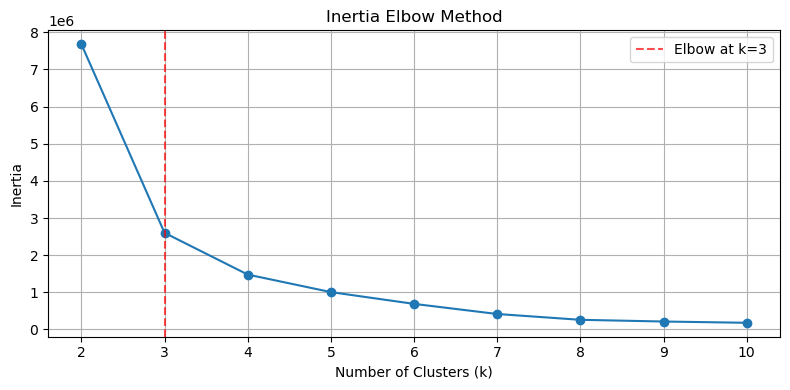

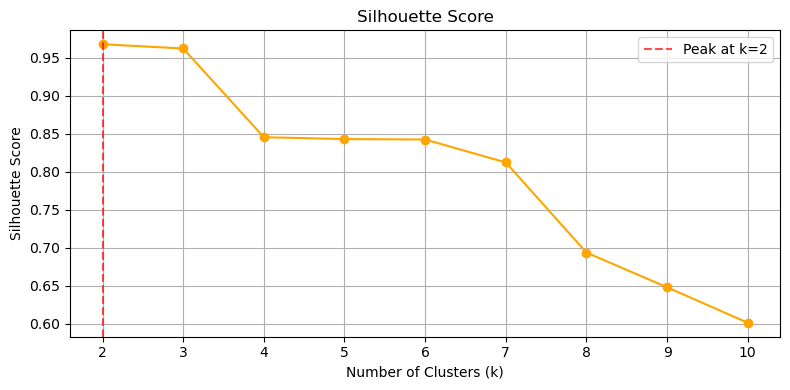

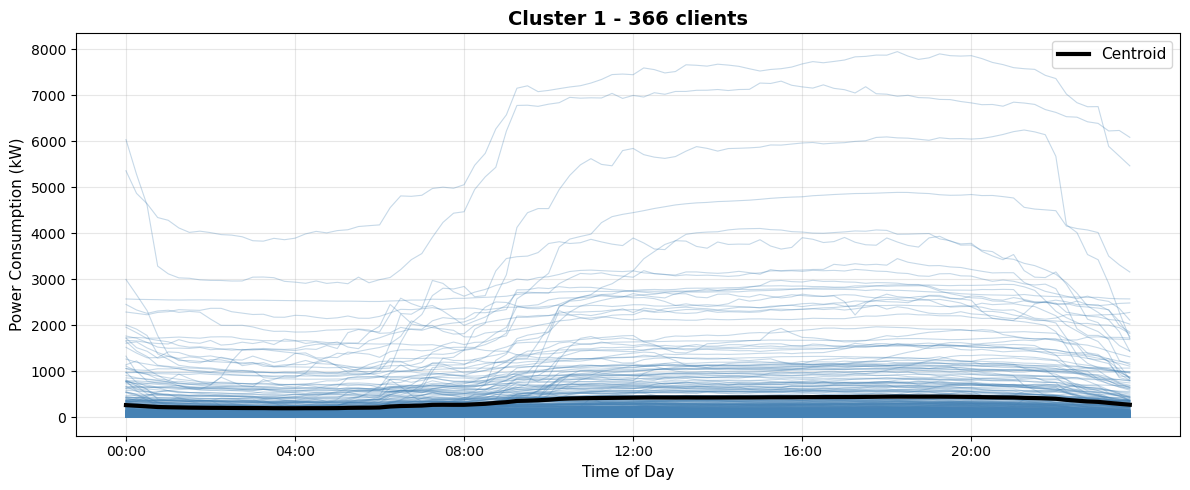

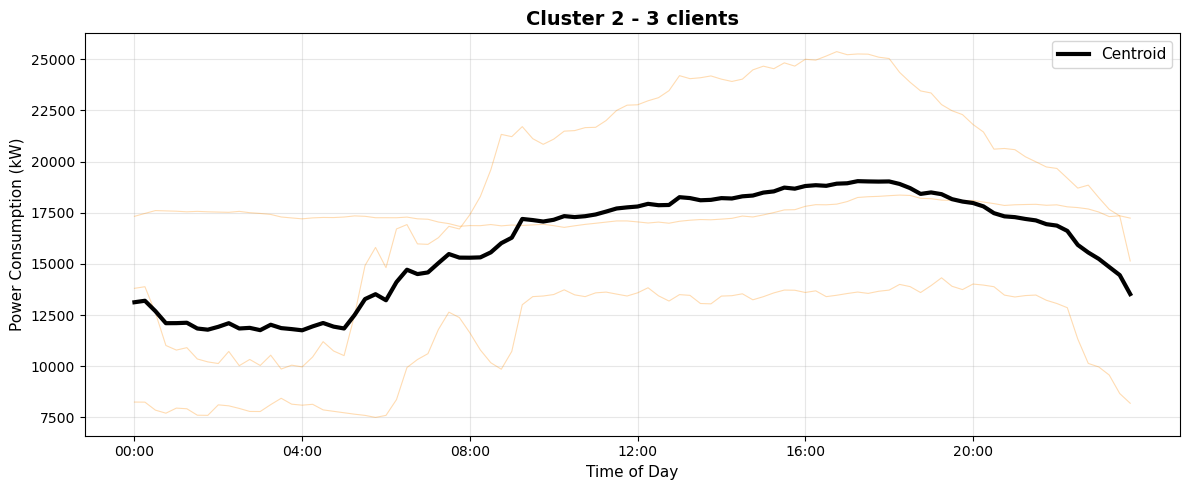

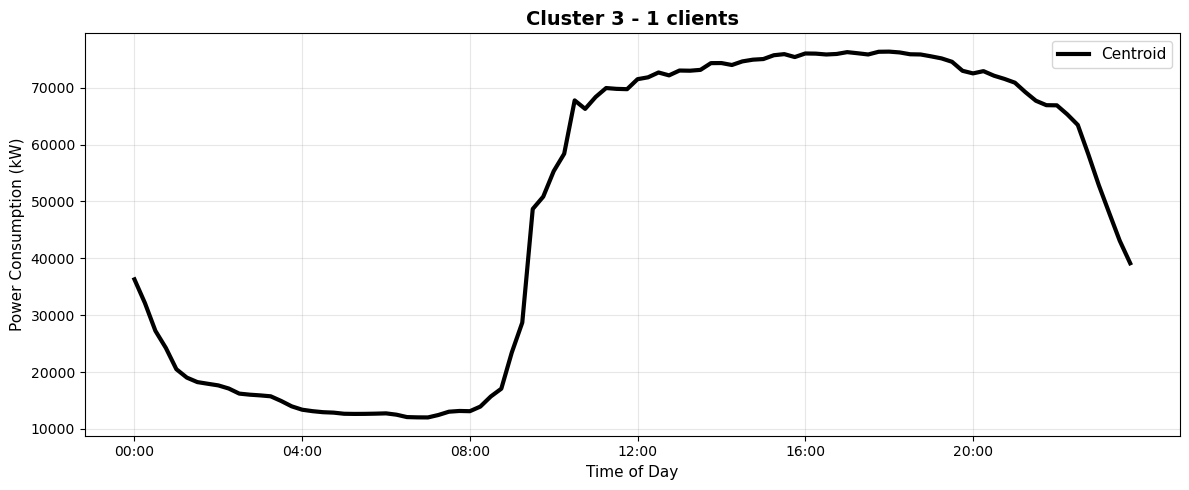

In [97]:
# 1a 

# Step 1: Preprocess and Filter for 2013-2014
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# Load the dataset
df = pd.read_csv(r'C:\Users\nghel\Downloads\LD2011_2014.txt', sep=';', index_col=0, parse_dates=True, decimal=',')

# Filter for 2013-2014
df = df['2013':'2014']

# Transpose so that each row is a client 
df_T = df.T

# Handle missing values
df_T = df_T.fillna(0)

# Normalize the data 
scaler = StandardScaler()
df_scaled = scaler.fit_transform(df_T)

# Step 2a: Inertia Elbow Method
inertia = []
k_range = range(2,11) 

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(df_scaled)
    inertia.append(kmeans.inertia_)

# Create the plot
plt.figure(figsize=(8, 4))
plt.plot(k_range, inertia, marker='o') 
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.title('Inertia Elbow Method')
plt.xticks(k_range)
plt.grid(True)
plt.tight_layout()
plt.axvline(x=3, color='red', linestyle='--', alpha=0.7, label='Elbow at k=3')
plt.legend()
plt.show()

# Result step 2a
# Optimal k = 3. The inertia plot shows a steep decline from k=2 to k=3, after which the curve begins to flatten out and the reductions in inertia become 
# progresively smaller with each additional cluster. This suggests that the elbow of the curve is at k=3 which means that beyond 3 clusters, the addition 
# of more cluters does not significantly improve the compactness of the clusters.

# Step 2b: Silhouette Score
silhouette_scores = []
for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = kmeans.fit_predict(df_scaled)
    score = silhouette_score(df_scaled, labels)
    silhouette_scores.append(score)

# Create the Plot
plt.figure(figsize=(8,4))
plt.plot(k_range, silhouette_scores, marker='o', color='orange')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score')
plt.xticks(k_range)
plt.grid(True)
plt.tight_layout()
plt.axvline(x=2, color='red', linestyle='--', alpha=0.7, label='Peak at k=2')
plt.legend()
plt.show()

# Result step 2b
# The silhouette score plot shows that optimal is k=2 (peaks at k=2, the highest score). This indicates that at at k=2, the clusters are most cohesive
# and well separated. After, the score drops as k increases which suggests that higher values of k introduce more overlap between clusters.

# OVERALL CONCLUSION - convenient number of clusters is k=3
# Although the silhouette score peaks at k=2, k=3 is a more convenient number of clusters because: 
# 1) Inertia elbow method clearly suggests k=3 as the point of diminishing returns in inertia reduction
# 2) Although k=2 produces the most statistically distinct clusters in the silhouette score, it is too coarse to reveal meaninigful differences in client
# behaviour - it would only split clients into "high" and "low" consumers
# 3) k=3 provides a more informative and interpretable segmentation. This allows us to differentiate between different consumption profiles such as 
# industrial, residential, and commercial consumers
# 4) The drop in silhouette score from k=2 to k=3 is quite small which means that the clusters at k=3 are still reasonably well-separated.

# 1b
# Fit final KMeans with chosen k
k = 3
kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
labels = kmeans.fit_predict(df_scaled)

# Centroids back in original (unscaled) units 
centroids = scaler.inverse_transform(kmeans.cluster_centers_)

# Compute mean daily profile per client
data_array = df_T.values
n_clients = data_array.shape[0]
n_steps = data_array.shape[1]
n_days = n_steps // 96

daily_mean = data_array[:, :n_days*96].reshape(n_clients, n_days, 96).mean(axis=1)
cent_daily = centroids[:, :n_days*96].reshape(k, n_days, 96).mean(axis=1)

time_labels = [f"{h:02d}:{m:02d}" for h in range(24) for m in (0, 15, 30, 45)]
x           = np.arange(96)
cluster_colors = ['steelblue', 'darkorange', 'seagreen']

# Plot for each cluster
for c in range(k):
    mask =labels ==c 
    n_in_cluster = mask.sum()
    client_profiles = daily_mean[mask]
    centroid_profile = cent_daily[c]

    fig, ax = plt.subplots(figsize=(12, 5))

    for profile in client_profiles:
        ax.plot(x, profile, 
                color=cluster_colors[c],
                alpha=0.3,
                linewidth=0.8)
                
    ax.plot(x, centroid_profile,
            color='black',
            linewidth=3,
            label='Centroid',
            zorder=5)

    ax.set_title(f'Cluster {c+1} - {n_in_cluster} clients',
                 fontsize=14, fontweight='bold')
    ax.set_xlabel('Time of Day', fontsize=11)
    ax.set_ylabel('Power Consumption (kW)', fontsize=11)

    tick_positions = list(range(0, 96, 16))
    ax.set_xticks(tick_positions)
    ax.set_xticklabels([time_labels[i] for i in tick_positions])

    ax.legend(fontsize=11)
    ax.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

# OBSERVATIONS:
# Cluster 2 and 3 only consist of 3 clients and 1 client, respectively. This can be due to the fact that only a few clients have extremely high 
# consumption of electricity compared to the rest therefore KMeans dedicated entire clusters to those outliers. One way of handling this is to remove 
# outliers before clustering. 



## Exercises 2

In this exercise you work with the daily curves of 1 single client.

First you create a list of arrays, each array containing a normalized curve for a day. The list contains 730 arrays, one for each of the days of 2013 and 2014.

a. Determine the optimal value for k-means. 

b. What are the clusters that you obtained represent?

In [ ]:
client = 'MT_022'
oneClient = data_13_14[client]
X = [] # a list of arrays, each array being a normalized curve for a day
for J in range(2*365):
    X.extend([np.array(oneClient[J*96:(J+1)*96])])#/np.mean(oneClient[J*96:(J+1)*96])])



In [ ]:
!pip install kneed

Number of daily curves: 730
Length of each curve: 96
Fitting k=2...
Fitting k=3...
Fitting k=4...
Fitting k=5...
Fitting k=6...
Fitting k=7...
Fitting k=8...
Fitting k=9...
Fitting k=10...
Elbow detected at k = 5


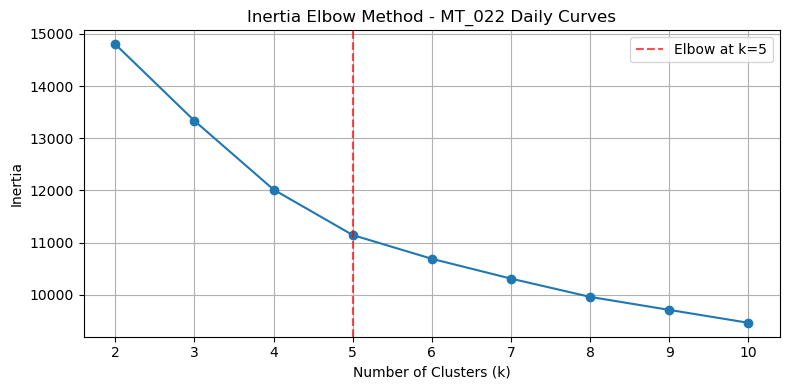

Silhouette k=2...
Silhouette k=3...
Silhouette k=4...
Silhouette k=5...
Silhouette k=6...
Silhouette k=7...
Silhouette k=8...
Silhouette k=9...
Silhouette k=10...
Best k by silhouette: 2


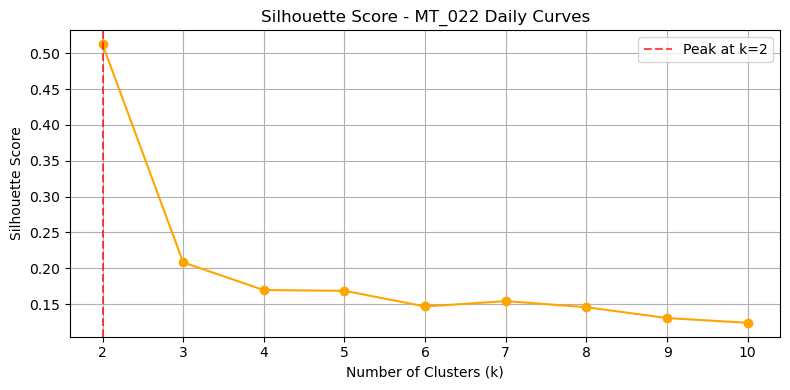


Fitted KMeans with k=5


In [100]:
# 2a

# Step 1: Extract and prepare daily curves for MT_022
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from kneed import KneeLocator

# Load and filter data for 2013-2014
df = pd.read_csv(r'C:\Users\nghel\Downloads\LD2011_2014.txt', sep=';', index_col=0, parse_dates=True, decimal=',')
df = df['2013':'2014']

# Extract single client
client = df['MT_022']

# Reshape into daily curves (each day = 96 values)
n_days = len(client) // 96
client_days = client.values[:n_days*96].reshape(n_days, 96) # shape: (730, 96)

# Normalize each day individually
daily_curves = []
for day in client_days:
    mean = day.mean()
    std = day.std()
    if std > 0:
        normalized = (day - mean) / std # normalizing each day on its own
    else: 
        normalized = day - mean # flat day (std = 0)
    daily_curves.append(normalized)

daily_curves = np.array(daily_curves) # shape: (730, 96)
print (f"Number of daily curves: {daily_curves.shape[0]}")
print(f"Length of each curve: {daily_curves.shape[1]}")

# Step 2a: Inertia Elbow Method
inertia = []
k_range = range(2, 11)

for k in k_range:
    print(f"Fitting k={k}...")
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(daily_curves)
    inertia.append(kmeans.inertia_)

kneelocator = KneeLocator(
    list(k_range),
    inertia,
    curve='convex',
    direction='decreasing'
)
print(f"Elbow detected at k = {kneelocator.elbow}")

plt.figure(figsize=(8, 4))
plt.plot(k_range, inertia, marker='o')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.title('Inertia Elbow Method - MT_022 Daily Curves')
plt.xticks(k_range)
plt.grid(True)
plt.tight_layout()
plt.axvline(x=kneelocator.elbow, color='red', linestyle='--',
            alpha=0.7, label=f'Elbow at k={kneelocator.elbow}')
plt.legend()
plt.show()

# Step 2b: Silhouette Score
silhouette_scores = []

for k in k_range:
    print(f"Silhouette k={k}...")
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = kmeans.fit_predict(daily_curves)
    score = silhouette_score(daily_curves, labels)
    silhouette_scores.append(score)

best_k_sil = list(k_range)[np.argmax(silhouette_scores)]
print(f"Best k by silhouette: {best_k_sil}")

plt.figure(figsize=(8,4))
plt.plot(k_range, silhouette_scores, marker='o', color='orange')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score - MT_022 Daily Curves')
plt.xticks(k_range)
plt.grid(True)
plt.tight_layout()
plt.axvline(x=best_k_sil, color='red', linestyle='--',
            alpha=0.7, label=f'Peak at k={best_k_sil}')
plt.legend()
plt.show()

k = 5
kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
labels = kmeans.fit_predict(daily_curves)
print(f"\nFitted KMeans with k={k}")


#### The following cell generates a list of all the days in the two years 2013-2014, which is helpful to answer part (b)

In [ ]:
from datetime import date, timedelta

d1 = date(2013, 1, 1)  # start date
d2 = date(2014, 12, 31)  # end date
delta = d2 - d1         # timedelta
daysyear = []
D = {0:'mon', 1:'tue', 2:'wed', 3:'thu', 4:'fri', 5:'sat', 6:'sun'}
for i in range(delta.days + 1):
    daysyear.extend([D[(d1 + timedelta(days=i)).weekday()]+"-"+str(d1 + timedelta(days=i))])

#### The following cell shows you how to do the following: given a list L, and a list of booleans B (True, False), get the sublist of L that corresponds to the True values in B. For example if L=[1,2,3,4] and B=[False,True,True,False], then the results is [2,3]. This is also helpful for part (b)

In [ ]:
from itertools import compress
L = [1,2,3,4]
B = [False, True, True, False]
list(compress(L, B))

In [102]:
# 2b

from itertools import compress
from datetime import date, timedelta

# Generate list of all days in 2013-2014
d1 = date(2013, 1, 1) # start date
d2 = date(2014, 12, 31) # end date
delta = d2 - d1 # timedelta
daysyear=[]
D = {0:'mon', 1:'tue', 2:'wed', 3:'thu', 4:'fri', 5:'sat', 6:'sun'}
for i in range(delta.days + 1):
    daysyear.extend([D[(d1 + timedelta(days=i)).weekday()]+"-"+str(d1 + timedelta(days=i))])

k = 5
kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
labels = kmeans.fit_predict(daily_curves)

# Get the days belonging to each cluster
for c in range(k):
    cluster_days = list(compress(daysyear, labels == c))

    # Counting weekday occurrences in this cluster
    weekdays = ['mon', 'tue', 'wed', 'thu', 'fri']
    weekend = ['sat', 'sun']
    n_weekdays = sum(1 for d in cluster_days if d[:3] in weekdays)
    n_weekends = sum(1 for d in cluster_days if d[:3] in weekend)
    print(f"\nCluster {c+1} - {len(cluster_days)} days")
    print(f" Weekdays: {n_weekdays}")
    print(f" Weekends: {n_weekends}")
    print(f" First few days: {cluster_days[:5]}")




Cluster 1 - 104 days
 Weekdays: 31
 Weekends: 73
 First few days: ['sun-2013-03-31', 'mon-2013-04-01', 'sat-2013-04-06', 'sun-2013-04-07', 'sat-2013-04-13']

Cluster 2 - 296 days
 Weekdays: 283
 Weekends: 13
 First few days: ['wed-2013-01-02', 'thu-2013-01-03', 'fri-2013-01-04', 'mon-2013-01-07', 'tue-2013-01-08']

Cluster 3 - 187 days
 Weekdays: 176
 Weekends: 11
 First few days: ['fri-2013-03-22', 'mon-2013-03-25', 'fri-2013-04-05', 'wed-2013-04-10', 'fri-2013-04-12']

Cluster 4 - 83 days
 Weekdays: 16
 Weekends: 67
 First few days: ['tue-2013-01-01', 'sat-2013-01-05', 'sun-2013-01-06', 'sat-2013-01-12', 'sun-2013-01-13']

Cluster 5 - 60 days
 Weekdays: 16
 Weekends: 44
 First few days: ['sat-2013-06-08', 'sat-2013-06-15', 'sat-2013-06-29', 'sat-2013-07-06', 'sun-2013-07-07']


In [ ]:
#  2b CONCLUSION
# The 5 clusters obtained represent distinct daily comsumption patterns for client MT_022 based on a combination of type of day and season. Cluster 2 is
# the dominant pattern capturing regular work days (296 days, 96% weekdays). Cluster 3 captures seasonal weekdays with a different consumption profile.
# This is likely driven by temperature differences in spring and fall. Clusters 1 and 4 represent non-working days - Cluster 1 captures spring/fall 
# weekends and public holidays, whereas Cluster 4 captures winter weekends and holidays. Cluster 5 represents a clear summer weekend pattern with reduced
# consupmption which reflects the Portuguese holiday season.